Before runing this script, you should have runned the ./DataLoader/Erowid.ipynb file to download user experiences and save them to 'experiences.pickle'.

In [62]:
import os
import pickle
from ipywidgets import interact
from matplotlib import use
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
from collections import Counter
from collections import defaultdict

import nltk
from nltk.stem.wordnet import WordNetLemmatizer

In [63]:
with open('./Data/experiences.pickle', 'rb') as handle:
    contents = pickle.load(handle)

In [3]:
def getExperiences(contents, separately = False):
    experiences = {}
    counts = {}
    
    if separately:
        for drug in contents.keys():
            experiences[drug] = [exp["text"] for exp in contents[drug]]      
    
    if not separately:
        for drug in contents.keys():
            experiences[drug] = ' '.join([exp["text"] for exp in contents[drug]])
    
    return experiences

In [4]:
experiencesAll = getExperiences(contents, separately = False)
experiencesSep = getExperiences(contents, separately = True)

In [5]:
experiencesAll.keys()

dict_keys(['25INBOMe', '2CB', '2CE', '2CI', '2CT2', '2CT7', '5MeODMT', '5MeODiPT', 'AMT', 'Alcohol', 'Amanitas', 'Amphetamines', 'Ayahuasca', 'Benzodiazepines', 'Cacti', 'Caffeine', 'Cannabinoid_Receptor_Agonists', 'Cannabis', 'Cocaine', 'Codeine', 'DMT', 'DPT', 'DXM', 'Datura', 'Dimenhydrinate', 'Diphenhydramine', 'Dreams', 'GHB', 'HB_Woodrose', 'Harmala_Alkaloids', 'Heroin', 'Hydrocodone', 'Inhalants', 'Kava', 'Ketamine', 'Kratom', 'LSD', 'MDMA', 'Methamphetamine', 'Methoxetamine_', 'Morning_Glory', 'Mushrooms', 'NBOMe_Series', 'NMDA_Antagonists', 'Nitrous_Oxide', 'Nutmeg', 'Opiates', 'Opioids', 'Pharmaceuticals', 'Pharms_Oxycodone', 'Pharms_Tramadol', 'Pharms_Zolpidem', 'Phenethylamine', 'SSRIs', 'Salvia_divinorum', 'Stimulants', 'Syrian_Rue'])

# Wordclouds per drug - most often words

In [6]:
def plotCloud(experiencesAll, drug, makePlot = False):
    wordcloud = WordCloud(max_font_size=45, relative_scaling=0.5).generate(experiencesAll[drug])
    plt.ioff()
    
    plt.figure(figsize = (10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    
    if makePlot:
        plt.show()
        return
    plt.ion()
    return plt

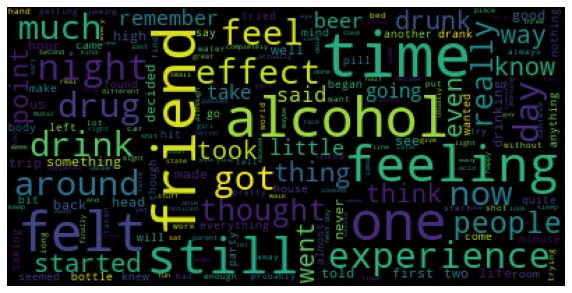

In [7]:
plotCloud(experiencesAll, "Alcohol").show()

# Wordclouds per drug II. - most unique words per drug

## Helping functions

In [31]:
def getValue(wordDict, word):
    try:
        if type(wordDict[word]) == list and len(wordDict[word]) == 0:
            raise Exception
            
        return wordDict[word]
    except:
        return 0
    
def cleanWord(word, toRemove = [",", ":", ";", 
                                ".", "-", "+",
                                "/", "\\" , "=", 
                                "(", ")", "@", 
                                "&", "\"", "'", 
                                "[", "]", "!", 
                                "?","%"]):
    for element in toRemove:
        word = word.replace(element,"")
        
    return word

def tagKeys(myDict):
    return nltk.pos_tag(list(myDict.keys()))
    

def mapTag(tag):
    tagMap = {"adjective": "JJ",
              "verb": "VB",
              "conjuction": "CC",
              "noun": "NN",
              "adverb": "RB"}
    
    return tagMap[tag]

def filterDict(myDict, exceptions, tag = ""):
    # the keys in the input dict are supposed to be normalized (lower, cleaned)
    myDict = {key:item for key, item in myDict.items() if key not in exceptions}
    
    if tag != "":
        tag = mapTag(tag)
        taggedKeys = tagKeys(myDict)
        myKeys = [key for key, myTag in taggedKeys if myTag.startswith(tag)]
        myDict = {key:value for key, value in myDict.items() if key in myKeys}
        
    return myDict

def getFirstN(myDict, n):
    return {key: myDict[key] for key in list(myDict)[:n]}

In [9]:
def lemmatizeText(text):
    wordList = nltk.word_tokenize(text)
    wnl = WordNetLemmatizer()
    lemmatizedText = ' '.join([wnl.lemmatize(wnl.lemmatize(word),"v") for word in wordList])
    return lemmatizedText

In [26]:
exceptions = ["i've", "i'd", "i'll",
             "i’ve", "i’d", "i’ll",
              "you’ve", "you’d", "you’ll",
             "you're", "you'd", "you'll",
              "they’ve", "they’d", "they’ll",
             "they're", "they'll", "it's",
             "can", "cannot", "-",
             "would", '–', "erowid", "", "''"]

## Extraction

In [11]:
def getCountsPerWord(drugExperience):
    return Counter(drugExperience.split())
    
def getRatiosPerWord(drugExperience):
    drugExperience = lemmatizeText(drugExperience)
    drugWordCounts = getCountsPerWord(drugExperience)
    wordSum = sum(drugWordCounts.values())
    
    return {cleanWord(word).lower(): count/wordSum for word, count in drugWordCounts.items()}

In [12]:
def getAvgRefRatiosPerWord(restExperiences):
    ratiosPerDrugs = {drug:getRatiosPerWord(restExperiences[drug]) for drug in restExperiences.keys()}
    byWords = defaultdict(list)

    for drug in ratiosPerDrugs.keys():
        for word in ratiosPerDrugs[drug].keys():
            word = cleanWord(word).lower()
            byWords[word] = getValue(byWords, word) + getValue(ratiosPerDrugs[drug], word)

    byWords = {word: ratio/len(ratiosPerDrugs) for word, ratio in byWords.items()}
    
    return byWords

In [13]:
def findDiffsPerWord(ratiosPerWordDrug, ratiosPerWordRest):
    diffsPerWord = {word: count - getValue(ratiosPerWordRest, word) for word, count in ratiosPerWordDrug.items()}
    
    return diffsPerWord

In [14]:
def sortDict(myDict, desc = True):
    return {key:value for key, value in sorted(myDict.items(), key = lambda item: item[1], reverse = desc)}

In [ ]:
def splitExperiences(experiencesAll, drug):
    localExperiences = experiencesAll.copy()
    
    # after this step the localExperiences dictionary excludes the drug, so it can be used as the reference
    drugExperiences = localExperiences.pop(drug, None)
    
    return drugExperiences, localExperiences

In [ ]:
def getBothRatios(drugExperiences, localExperiences):
    ratiosPerWordDrug = getRatiosPerWord(drugExperiences)
    ratiosPerWordRest = getAvgRefRatiosPerWord(restExperiences)
    
    return ratiosPerWordDrug, ratiosPerWordRest

In [64]:
def getUniqueWords(ratiosPerWordDrug, ratiosPerWordRest, drug, exceptions, tag, limit):
    diffsPerWord = sortDict(findDiffsPerWord(ratiosPerWordDrug, ratiosPerWordRest), desc = True)
    uniqueWords = getFirstN(filterDict(diffsPerWord, exceptions, tag), limit).keys()
    
    return uniqueWords

In [ ]:
def createTextFromUniques(uniqueWords):
    
    return text

In [65]:
uniqueWords = getUniqueWords(experiencesAll, "Alcohol", exceptions, tag = "verb", limit = 50)

In [68]:
ratiosPerWordDrug = getRatiosPerWord(experiencesAll["Alcohol"])

In [69]:
ratiosPerWordDrug

{'hello': 9.989431181809645e-06,
 '': 1.997886236361929e-06,
 'my': 3.995772472723858e-06,
 'name': 1.997886236361929e-06,
 'be': 1.997886236361929e-06,
 'donovan': 3.995772472723858e-06,
 'and': 3.995772472723858e-06,
 'this': 1.997886236361929e-06,
 'will': 2.397463483634315e-05,
 'first': 4.395349719996244e-05,
 'report': 3.995772472723858e-06,
 'regard': 4.5951383436324366e-05,
 'experience': 3.995772472723858e-06,
 'of': 1.5983089890895433e-05,
 'a': 1.997886236361929e-06,
 'psychedelic': 3.995772472723858e-06,
 'nature': 5.993658709085787e-06,
 'just': 1.997886236361929e-06,
 'to': 1.997886236361929e-06,
 'provide': 7.192390450902945e-05,
 'little': 1.997886236361929e-05,
 'background': 9.989431181809645e-06,
 'myself': 1.997886236361929e-06,
 'the': 1.997886236361929e-06,
 'circumstance': 3.5961952254514726e-05,
 'surround': 9.58985393453726e-05,
 'encounter': 3.995772472723858e-05,
 'i': 1.997886236361929e-06,
 'tell': 1.997886236361929e-06,
 'you': 1.997886236361929e-06,
 'tha

## Prepare and save texts to visualize

In [43]:
from math import floor

In [55]:
len(uniqueWords.keys())

50

In [60]:
len(set(''.join([floor(1000*uniqueWords[key]/sum(uniqueWords.values())) * (key + " ") for key in uniqueWords.keys()])))

24

In [ ]:
def createText(ratioDict):
    

In [ ]:
def createAllText(experiencesAll, drugList, exceptions, tag, limit):
    allTexts = defaultDict(list)

## Visualization

### Create dummy text based on the ratios

# Word counts per drug

## Extraction

In [12]:
def getCounts(experiencesSep, drug):
    wordCounts = [len(set(crExp.split())) for crExp in experiencesSep[drug]]
    return pd.DataFrame(wordCounts).describe()

In [14]:
getCounts(experiencesSep, "Alcohol")

,0
count,538.000000
mean,385.232342
std,242.272159
min,55.000000
25%,217.000000
50%,352.000000
75%,480.500000
max,2016.000000


## Visualization